# TileDB-SOMA ML Webinar: Cell Similarity Search

In this tutorial, you will use [TileDB-Vector-Search](https://cloud.tiledb.com/academy/structure/ai-ml/vector-search/) to perform cell similarity search using:
- [CZI CELLxGENE Census](https://chanzuckerberg.github.io/cellxgene-census) (74 million human reference cells)
- [scVI embeddings](https://www.nature.com/articles/s41592-018-0229-2)

You can use cell similarity search for:

- Sample reference mapping:
  - Automatic cell annotation based on retrieved similar cells (e.g. cell_type) to bootstrap the analysis of a new sample.

- Interactive analysis:
  - For cells of interest, interactively explore similar cells from the reference dataset, applying structured restricts.

**Contents**
* [Setup](#setup)
* [Indexing](#indexing)
* [Similarity Search](#similarity-search)
* [Sample reference mapping](#sample-reference-mapping)
* [Cell interactive analysis](#cell-interactive-analysis)


## Setup <a id="setup"></a>

Import libraries and setup URIs.

In [1]:
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import tiledb.cloud
from tiledb.vector_search.object_api import object_index

warnings.filterwarnings("ignore")

index_uri = "tiledb://TileDB-Inc/cell-census-2024-07-01-scvi-index"

# Set region and no_sign_request for S3
config = tiledb.cloud.Config().dict()
config["vfs.s3.region"] = "us-west-2"
config["vfs.s3.no_sign_request"] = "true"

## Indexing <a id="indexing"></a>

You can index the Census in TileDB using distributed execution for both embedding generation and vector indexing. 

![Census embedding generation](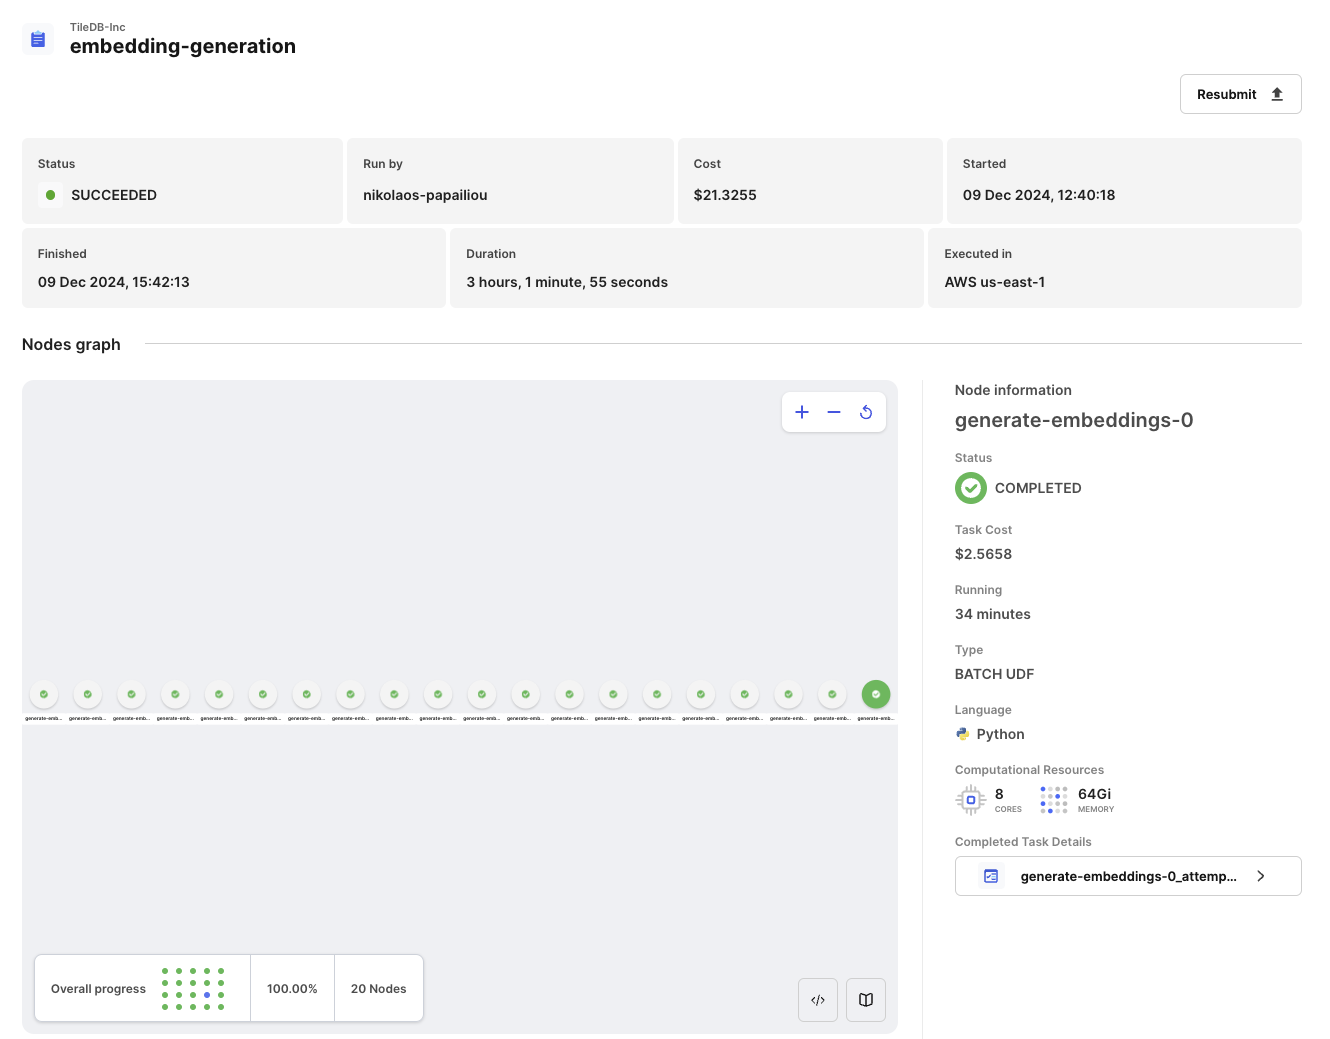
)

![Census vector ingestion](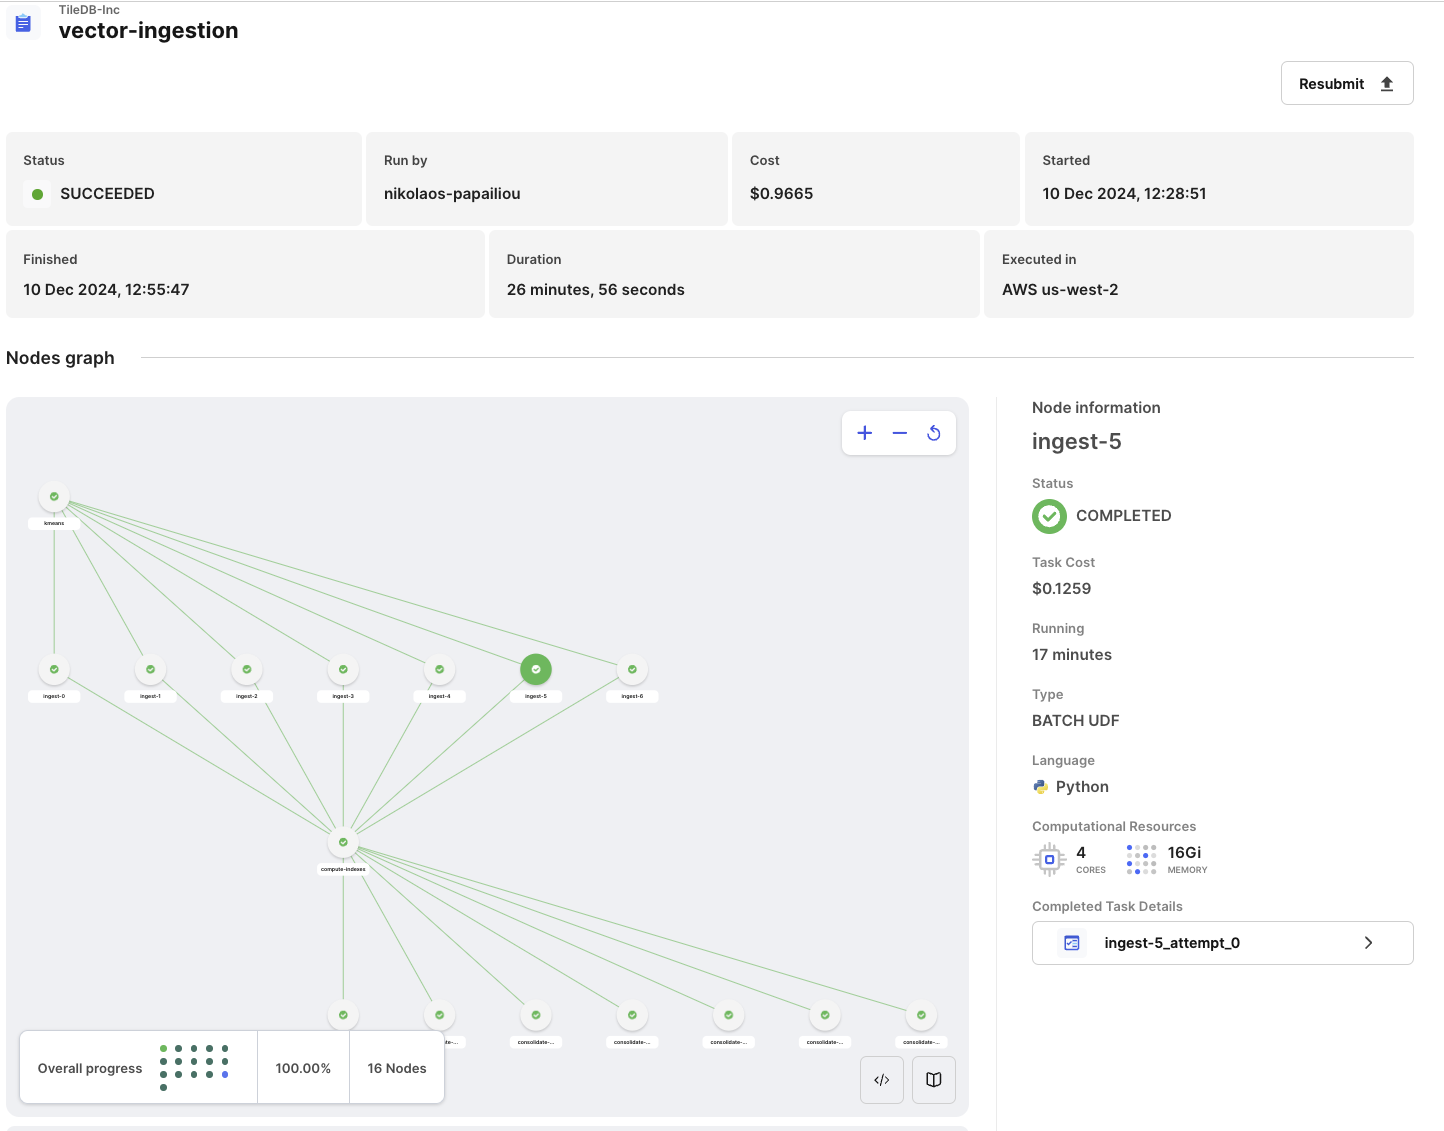
)

## Similarity Search <a id="similarity-search"></a>

First, lets open the vector index.

In [2]:
index = object_index.ObjectIndex(
    uri=index_uri,
    config=config,
    memory_budget=1_000_000,
    load_metadata_in_memory=False,
)

Load the **pbmc3k** cell sample consiting of 3k individual cells.

In [3]:
def get_pbmc3k():
    adata = sc.datasets.pbmc3k()
    adata.var["feature_id"] = adata.var["gene_ids"]
    return adata


adata = get_pbmc3k()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids', 'feature_id'

## Sample reference mapping <a id="sample-reference-mapping"></a>

Query Census to retrieve the *k* most similar cells for each of the sample cells. 

This is using the TileDB-Vector-Search object level query interface to:
- Compute sample cell embeddings.
- Retrieve similar cell ids from the vector search index.
- Fetch observations of the similar cell ids from Census.

In [4]:
%%time
distances, neighbour_ids, neighbour_obs = index.query(
    {"anndata": adata}, k=10, nprobe=1, return_objects=False
)

INFO     Found 54.675% reference vars in query data.                                                               
CPU times: user 26.9 s, sys: 11.8 s, total: 38.7 s
Wall time: 53.5 s


Here are the results for a random cell

In [5]:
def tiledb_to_pandas(obs, cell_id):
    new_obs = {}
    column_names = ["soma_joinid", "cell_type", "tissue", "disease"]
    for column_name in column_names:
        new_obs[column_name] = obs[column_name][cell_id]
    return pd.DataFrame(data=new_obs)


tiledb_to_pandas(neighbour_obs, 42)

,soma_joinid,cell_type,tissue,disease
0,21651228,"CD8-positive, alpha-beta memory T cell",blood,COVID-19
1,35014199,"effector memory CD8-positive, alpha-beta T cell",blood,normal
2,44414446,"CD8-positive, alpha-beta T cell",blood,COVID-19
3,21680805,"CD8-positive, alpha-beta memory T cell",blood,COVID-19
4,58301278,"CD8-positive, alpha-beta T cell",lung,lung adenocarcinoma
5,55062865,"CD8-positive, alpha-beta T cell",lung,lung adenocarcinoma
6,35524070,"effector memory CD4-positive, alpha-beta T cell",blood,normal
7,11498231,"CD8-positive, alpha-beta memory T cell",blood,COVID-19
8,50479431,"effector memory CD4-positive, alpha-beta T cell",blood,normal
9,40312561,"CD4-positive, alpha-beta T cell",blood,COVID-19


### Predict cell types

Use the similar cell annotations to predict each cell type using a majority vote.

In [6]:
cell_predictions = []
for idx in range(neighbour_obs["cell_type"].shape[0]):
    annotations, counts = np.unique(neighbour_obs["cell_type"][idx], return_counts=True)
    annotation = annotations[np.argsort(-counts)][0]
    cell_predictions.append(annotation)

Display the cell annotated types using a UMAP plot based on the scVI embeddings and the predicted cell_types.

INFO     Found 54.675% reference vars in query data.                                                               


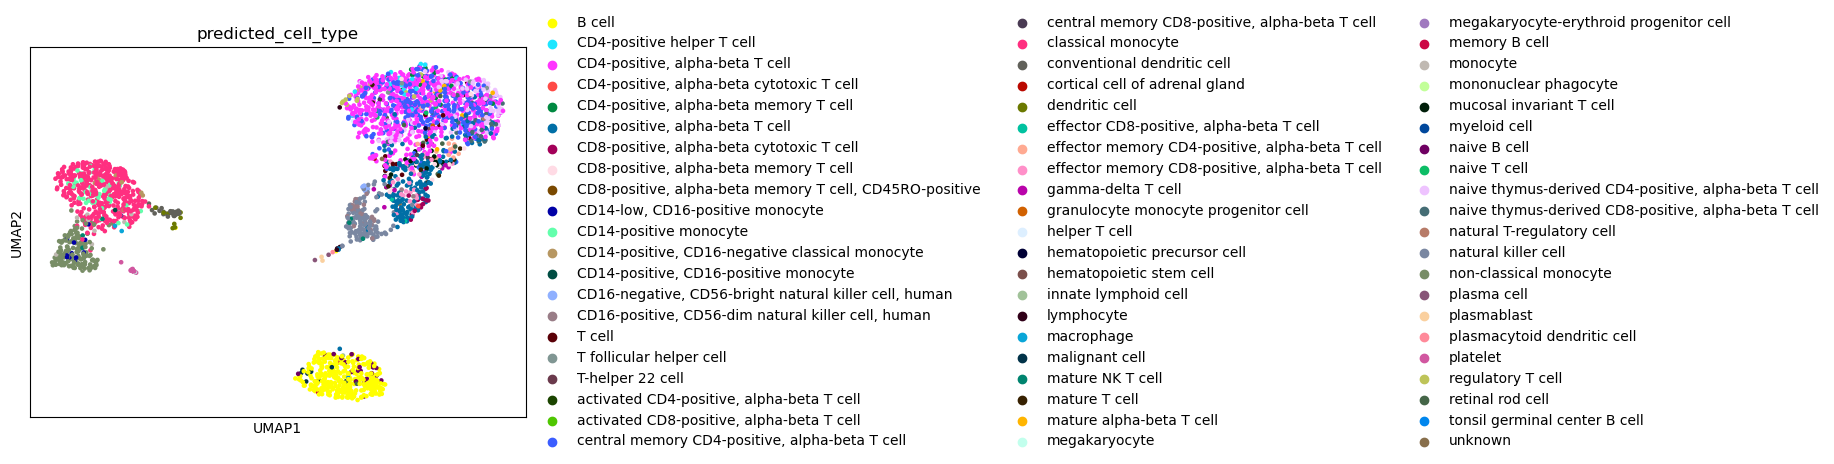

In [7]:
adata = get_pbmc3k()
adata.obsm["scvi"] = index.embedding.embed({"anndata": adata}, None)
adata.obs["predicted_cell_type"] = cell_predictions

sc.pp.neighbors(adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color="predicted_cell_type")

You can reduce the `cell_type` label noise by annotating the leiden clusters by popular vote, whereby each cluster gets assigned the most common predicted cell type from the previous step.

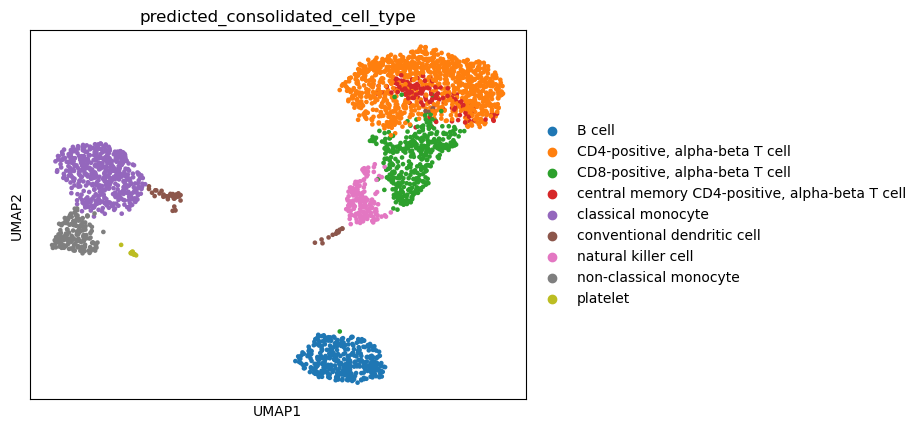

In [8]:
adata.obs["predicted_consolidated_cell_type"] = ""
for leiden_cluster in adata.obs["leiden"].drop_duplicates():
    most_popular_type = (
        adata.obs.loc[adata.obs["leiden"] == leiden_cluster,]
        .value_counts("predicted_cell_type")
        .index[0]
    )
    adata.obs.loc[
        adata.obs["leiden"] == leiden_cluster, "predicted_consolidated_cell_type"
    ] = most_popular_type
sc.pl.umap(adata, color="predicted_consolidated_cell_type")

## Cell interactive analysis <a id="cell-interactive-analysis"></a>

Load the **pbmc3k** cell sample and pick a random cell of interest.

In [9]:
adata = get_pbmc3k()
cell_id = 42
cell_adata = adata[cell_id]

Fetch similar cells from Census

In [10]:
%%time
distances, neighbour_ids, neighbour_obs = index.query(
    {"anndata": cell_adata}, k=100, nprobe=1, return_objects=False
)

INFO     Found 54.675% reference vars in query data.                                                               
CPU times: user 6.85 s, sys: 3.37 s, total: 10.2 s
Wall time: 6.75 s


### Analyse the similar cells 

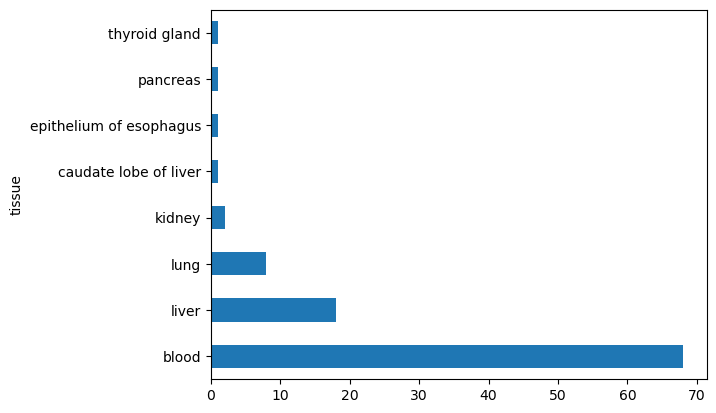

In [11]:
ax = tiledb_to_pandas(neighbour_obs, 0).value_counts("tissue").plot.barh()

### Refine similarity query

Now you can fetch similar cells only from blood tissue

In [12]:
%%time
adata = get_pbmc3k()
cell_adata = adata[cell_id]


def tissue_filter_fn(row):
    return row["tissue"] == "blood"


distances, cells, neighbour_obs = index.query(
    {"anndata": cell_adata},
    metadata_df_filter_fn=tissue_filter_fn,
    k=100,
    nprobe=1,
    return_objects=False,
)

INFO     Found 54.675% reference vars in query data.                                                               
CPU times: user 17 s, sys: 10.6 s, total: 27.6 s
Wall time: 10.2 s


And analyse the similar cells disease histogram.

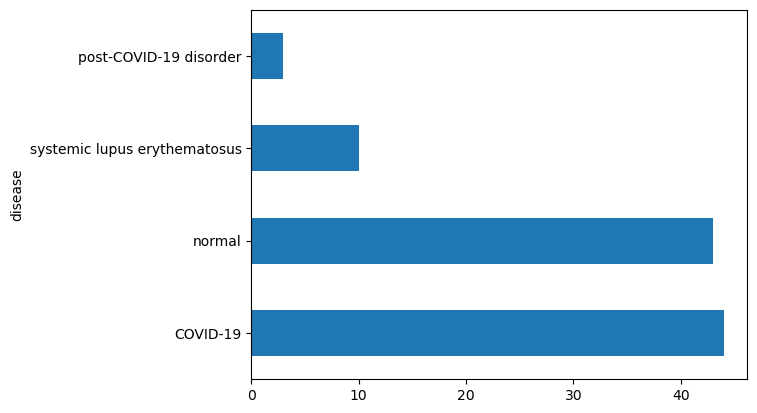

In [13]:
ax = tiledb_to_pandas(neighbour_obs, 0).value_counts("disease").plot.barh()